# Part I: Shift transcripts that are close to the cell wall if needed

- Push transcripts that are sitting right on the cell wall to the cytoplasm with them most gene transcripts
- Check if transcripts are clustered next to the wall and if some of those transcripts went slightly astray
- Save corrected spatial locations of cytoplasmic transcripts

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tifffile as tf
from glob import glob
import os

from scipy import ndimage
from sklearn import neighbors

from importlib import reload
import utils

# Set directory structure

- `wsrc`: directory with 2D TIFs of cell walls
- `nsrc`: directory with 2D TIFs of cell nuclei
- `csrc`: directory with transcripts spatial location and cell metadata
- `dst`: directory to save the corrected transcript location

### Correction parameters

- We are going to evaluate for possible correction all transcripts such that
    - are within `maxdwall` pixels from a cell wall (chessboard distance)
    - Have at least `minneighs` neighbors in a `radius` pixel radius
- If more than `minprob`% of its neighbors belong to a different cell, we assume that this transcript was mislabeled and nudge it toward the cell with the most transcripts

### Setting things up

- Compute a chessboard distance transform of the cell wall
- Get individual cells through `ndimage.label`

In [4]:
struc1 = ndimage.generate_binary_structure(2,1)
struc2 = ndimage.generate_binary_structure(2,2)
theta = np.linspace(-np.pi, np.pi, 50)

wsrc = '../cell_dams/'
nsrc = '../nuclear_mask/'
csrc = '../data/'
dst = '../translocs/'

sample = 'D2'

radius = 30
maxdwall = 6
minneighs = 5
minprob = 74

dst += sample + os.sep
if not os.path.isdir(dst):
    os.mkdir(dst)

wall = tf.imread(wsrc + sample + '_dams.tif').astype(bool)

edt = ndimage.distance_transform_cdt(wall, 'chessboard')
label, cellnum = ndimage.label(wall, struc1)
print('Detected',cellnum,'cells')

Detected 2937 cells


1.12% of pixels labeled as nuclei


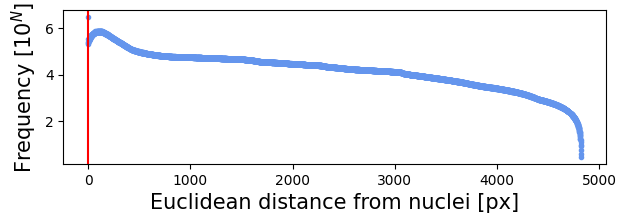

In [33]:
nuccutoff = 2
nuclei = tf.imread(nsrc + sample + '_EDT.tif')

hist, bins = np.histogram(nuclei, bins = range(0, int(np.ceil(nuclei.max())) + 1))
fs = 15
fig, ax = plt.subplots(1,1,figsize=(7,2))
ax = np.atleast_1d(ax).ravel()

ax[0].scatter(bins[:-1], np.log10(hist) , c='cornflowerblue', marker='.')
ax[0].axvline(nuccutoff, c='r')
ax[0].set_ylabel('Frequency [$10^N$]', fontsize=fs)
ax[0].set_xlabel('Euclidean distance from nuclei [px]', fontsize=fs);

nuclei = nuclei < nuccutoff
print('{:.2f}% of pixels labeled as nuclei'.format(np.sum(nuclei)/nuclei.size*100))

- Load spatial locations of all transcripts of all genes
- Discard those located in the nuclei

In [40]:
filename = csrc + sample + '_data/32771-slide1_' + sample + '_results.txt'
data = pd.read_csv(filename, header=None, sep='\t').drop(columns=[4])
foo = len(data)
print('Originally found', foo, 'total transcripts')
data.columns = ['X', 'Y', 'Z', 'T']
data = data.loc[ ~nuclei[data['Y'], data['X']] ]
print('Reduced to', foo, 'after removing those in nuclei [kept {:.02f}% of the originals]'.format(len(data)/foo*100) )

transcriptomes, invidx, tsize = np.unique(data.iloc[:,-1], return_index = False, return_inverse=True, return_counts=True) 
print('\nFound data for', len(transcriptomes), 'transcriptomes')

data.iloc[:,:3].describe().drop(index='count').T.astype(dict(zip(['min','25%','50%','75%','max'], [int for i in range(5)])))

Originally found 3830384 total transcripts
Reduced to 3830384 after removing those in nuclei [kept 96.52% of the originals]

Found data for 97 transcriptomes


,mean,std,min,25%,50%,75%,max
X,9038.412803,3458.651511,3,6125,9178,11911,17146
Y,8164.516985,2934.356980,2,5730,8017,10392,17133
Z,28.159784,7.126370,1,23,28,33,61


- Select one transcript index `tidx`
- Keep track of which transcripts are in which cells through `tlabs`
- Keep track of how many transcripts are in every cell with `tpercell`

In [50]:
tidx = 26

coords = data.loc[invidx == tidx , ['X', 'Y', 'Z'] ].values.T
tlabs = label[coords[1], coords[0] ].astype(int)
tpercell, _ = np.histogram(tlabs, np.arange(cellnum+2))
print(transcriptomes[tidx], coords.shape, sep='\t')

GLYMA_05G092200	(3, 764852)


# Deal with transcripts on the edge

- If transcript is right on top of a cell wall, nudge it to the cytosol of the cell with the most transcript.

In [51]:
reload(utils)
foo = np.sum(tlabs == 0)
print('Initially, there are\t',foo,'\ttranscripts on the walls',sep='')
print(np.nonzero(tlabs == 0)[0][:15])
if foo > 0:
    tlabs, coords = utils.correct_boundary_transcripts(tlabs, coords, label, tpercell, R=5)
    foo = np.sum(tlabs == 0)
    print('Now there are\t',foo,'\ttranscripts on the walls',sep='')

Initially, there are	11764	transcripts on the walls
[  87  206  302  314  439  738  875  969  997 1107 1372 1565 1566 1604
 1619]
Now there are	0	transcripts on the walls


![](https://raw.githubusercontent.com/ejamezquita/ejamezquita.github.io/main/mcarto/figs/shifted_transcript.svg)

# Deal with misplaced transcripts

- Distances are in 3D
- Have a closer look at transcripts within `maxdwall` pixels from a wall (chessboard distance)
    - **And** that have at least `minneighs` neighbors in a `radius` pixel radius
    - To avoid unnecessary NN computations, we are going to limit the NN scope to transcripts such that are within `radius` pixels from a cell wall `cdtmask`
- *If* more than `minprob`% of its neighbors belong to a different cell, we assume that this transcript was mislabeled and nudge it toward the cell with the most transcripts
- All this nudging might affect the location of some clusters which in turn could warrant more nudging
- Thus, the evaluation is repeated over and over again until no nudging is necessary

In [59]:
foo = 100
iters = 0

if np.sum(edt[coords[1], coords[0]] < maxdwall) > 0:

    cdtmask = np.nonzero(edt[coords[1], coords[0]] < radius)[0]
    cdtlabs = tlabs[cdtmask].copy()
    cdtcoords = coords[ :,  cdtmask].copy()
    edtmask = edt[cdtcoords[1], cdtcoords[0]] < maxdwall
    edtvals = np.nonzero(edtmask)[0]

    while (foo  > 0) and (iters < 20):
        iters += 1    
        foo, cdtlabs, cdtcoords = utils.correct_shifted_transcripts(cdtlabs, cdtmask, cdtcoords, edtmask, edtvals, label, maxdwall, minneighs, minprob)
        print('Iteration: ', iters, '\tShifted\t',foo,' transcripts', sep='')
    
    shiftmask = np.any(cdtcoords != coords[ :,  cdtmask], axis=0)
    print('Shifted\t',np.sum(shiftmask),'\ttranscripts in total', sep='')
shiftidx = np.nonzero(shiftmask)[0]

Iteration: 1	Shifted	5823 transcripts
Iteration: 2	Shifted	1722 transcripts
Iteration: 3	Shifted	550 transcripts
Iteration: 4	Shifted	173 transcripts
Iteration: 5	Shifted	49 transcripts
Iteration: 6	Shifted	15 transcripts
Iteration: 7	Shifted	8 transcripts
Iteration: 8	Shifted	3 transcripts
Iteration: 9	Shifted	1 transcripts
Iteration: 10	Shifted	0 transcripts
Shifted	8344	transcripts in total
[  65  108  121  180  396  608  617  693  714  721  735  766  810  882
  982  994 1034 1063 1103 1109]


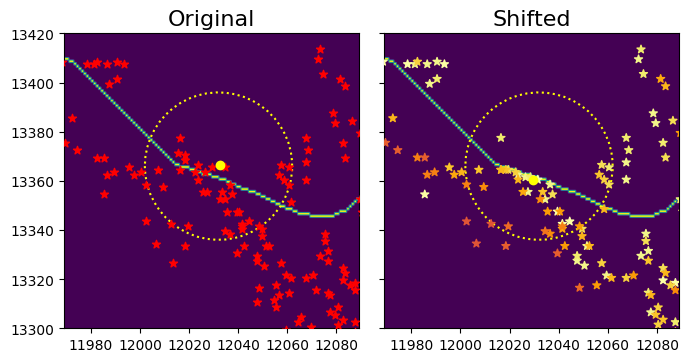

In [65]:
i = shiftidx[8005]

R = radius*2
x,y,z = cdtcoords[:,i]
colors = np.abs(z - cdtcoords[2])
vmax = np.max(colors)

ss = np.s_[max([0, y - R]) : min([label.shape[0], y + R]), 
           max([0, x - R]) : min([label.shape[1], x + R])]
extent = (ss[1].start, ss[1].stop, ss[0].start, ss[0].stop)

fig, ax = plt.subplots(1,2,figsize=(7,3.5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); fs = 16

for j in [0,1]:
    ax[j].imshow(wall[ss], cmap='viridis_r', origin='lower', extent=extent)
    ax[j].set_aspect('equal')
    ax[j].set_xlim(extent[0],extent[1])
    ax[j].set_ylim(extent[2],extent[3])

x0,y0,z0 = coords[:, cdtmask][:,i]
ax[0].set_title('Original', fontsize=fs)
ax[0].scatter(coords[0]+.5, coords[1]+.5, c='r', marker='*', zorder=3, alpha=1);
ax[0].scatter([x0+.5], [y0+.5], c='yellow', marker='o', zorder=4, alpha=1);
ax[0].plot(radius*np.cos(theta)+x0, radius*np.sin(theta)+y0, c='yellow', ls=':')

ax[1].set_title('Shifted', fontsize=fs)
ax[1].scatter(cdtcoords[0]+0.5, cdtcoords[1]+.5, c=colors, marker='*', zorder=3, alpha=1, cmap='inferno_r', vmin=0, vmax=vmax);
ax[1].scatter([x+.5], [y+.5], c='yellow', marker='o', zorder=4, alpha=1);
ax[1].plot(radius*np.cos(theta)+x0, radius*np.sin(theta)+y0, c='yellow', ls=':')

fig.tight_layout();

# Save Results

- Some transcripts might have been nudged into a nucleus, so they are removed
- The number of these accidentally removed transcripts is fairly low, so there should be no major changes down the line.

In [68]:
coords[:, cdtmask] = cdtcoords
print(coords.shape, tlabs.shape, cdtlabs.shape, cdtcoords.shape, sep='\t')
np.sum(nuclei[coords[1], coords[0]])
coords = coords[:, ~nuclei[coords[1], coords[0]]]

(3, 764852)	(764852,)	(624068,)	(3, 624068)


8

In [82]:
filename = dst + 'location_corrected_' + sample +'_-_' + transcriptomes[tidx] + '.csv'
print(filename)
df = pd.DataFrame(coords.T)
#df['foo'] = transcriptomes[tidx]
df.to_csv(filename, header=False, index=False)

../translocs/D2/location_corrected_D2_-_GLYMA_05G092200.csv
